# Check angle boxplot BEFORE last scan

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import iqr

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils import utils
import pp_utils.inspection_angle as ia

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [11]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [12]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [13]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


In [14]:
CLUSTER_STR_7 = [
    "R+/Straight", "R+/Curved-1", "R+/Curved-2",
    "L+/Straight", "L+/Curved-1", "L+/Curved-2"
]

## Gather data for all clicks before last scan

In [15]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Functions

In [16]:
def get_clicks(trial_idx, timeframe):
    """
    timeframe: "before" or "during" the last scan
    """
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
    
    if timeframe == "before":
        # Filter out only clicks before the last scan
        df_ch0 = utils.filter_clicks_before_last_scan(
            df_h=tp.df_hydro_ch0.copy(),
            th_RL=MISC_PARAMS["th_RL"],
            time_last_scan_start=tp.last_scan_start,
            time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
        )
        df_ch1 = utils.filter_clicks_before_last_scan(
            df_h=tp.df_hydro_ch1.copy(),
            th_RL=MISC_PARAMS["th_RL"],
            time_last_scan_start=tp.last_scan_start,
            time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
        )
    elif timeframe == "during":
        # Filter out only clicks during the last scan
        df_ch0 = utils.filter_clicks_during_last_scan(
            df_h=tp.df_hydro_ch0.copy(),
            th_RL=MISC_PARAMS["th_RL"],
            time_last_scan_start=tp.last_scan_start,
            time_last_scan_end=tp.last_scan_end
        )
        df_ch1 = utils.filter_clicks_during_last_scan(
            df_h=tp.df_hydro_ch1.copy(),
            th_RL=MISC_PARAMS["th_RL"],
            time_last_scan_start=tp.last_scan_start,
            time_last_scan_end=tp.last_scan_end
        )
    else:
        raise ValueError(f"timeframe={timeframe} not supported!")


    # Print if decision made before reaching range threshold
    if tp.last_scan_end < tp.last_scan_start:
        print(f"Trial {trial_idx}: last scan start/end time invalid!")

    # Check if any df is empty
    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")
    
    return df_ch0, df_ch1

In [17]:
# Scenarios
SCENARIO_STR = [
    "TC1", "TC2", "TC3", "TC4",
    "CT1", "CT2", "CT3", "CT4",
]

In [18]:
TARGET_ANGLE_STR_NEW = [
    "R+/0", "R+/45", "R+/90", "R+/135",
    "L+/0", "L+/45", "L+/90", "L+/135",
]

## Gather trial index for cluster vs scenario grouping

In [19]:
trial_idx_cluster_dict = dict()
for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    idx_accum = []

    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        idx_accum += list(df_tca.index)

    trial_idx_cluster_dict[CLUSTER_STR_7[cluster_idx]] = idx_accum

In [20]:
for k in trial_idx_cluster_dict:
    print(f"{k}: {len(trial_idx_cluster_dict[k])}")

R+/Straight: 16
R+/Curved-1: 16
R+/Curved-2: 9
L+/Straight: 23
L+/Curved-1: 8
L+/Curved-2: 6


In [21]:
trial_idx_scenario_dict = dict()
for tca in SCENARIO_STR:
    idx_accum = []

    for cluster_idx in range(6):
        df_cluster = df_cluster_clean_7[cluster_idx]
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        idx_accum += list(df_tca.index)
    
    trial_idx_scenario_dict[tca] = idx_accum

In [22]:
for k in trial_idx_scenario_dict:
    print(f"{k}: {len(trial_idx_scenario_dict[k])}")

TC1: 12
TC2: 8
TC3: 10
TC4: 11
CT1: 6
CT2: 8
CT3: 10
CT4: 13


In [23]:
def plot_iqr(clicks_before, clicks_during, cut_list, flip_xticks, figsize=(6,14)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bp_before = plt.boxplot(
        list(clicks_before.values()),
        positions=np.arange(len(clicks_before))-0.25,
        vert=False,
        widths=0.5,
        showcaps=False,
        patch_artist=True,
        boxprops=dict(facecolor="peru", color="none"),
        flierprops=dict(marker=".", markerfacecolor="k", markersize=5, markeredgecolor="none"),
        whiskerprops=dict(lw=1),
        medianprops=dict(color="k",lw=1.5),
        manage_ticks=False,
    )
    bp_during = plt.boxplot(
        list(clicks_during.values()),
        positions=np.arange(len(clicks_during))+0.25,
        vert=False,
        widths=0.5,
        showcaps=False,
        patch_artist=True,
        boxprops=dict(facecolor="gold", color="none"),
        flierprops=dict(marker=".", markerfacecolor="k", markersize=5, markeredgecolor="none"),
        whiskerprops=dict(lw=1),
        medianprops=dict(color="k",lw=1.5),
        manage_ticks = False,
    )

    # Add legend
    ax.legend(
        [bp_before["boxes"][0], bp_during["boxes"][0]],
        ["Before last scan", "During last scan"],
        loc='upper right', fontsize=12,
    )

    if flip_xticks:
        plt.xticks(np.arange(-90, 100, 15))
        plt.xlim([-30, 90])
    else:
        plt.xticks(np.arange(0, 360, 30))
        plt.xlim([60, 290])

    for cc in cut_list[:-1]:
        plt.gca().axhline(y=cc-0.5, color="k", lw=1.5)

    return fig, ax

## Plot all clusters together

In [24]:
click_ch1_all_before = dict()
click_ch1_all_during = dict()
click_ch1_all_before_flip = dict()
click_ch1_all_during_flip = dict()
str_all = dict()
iqr_all_before = dict()
iqr_all_during = dict()
buzz_str = ""
buzz_trial_idx = []

for k in trial_idx_cluster_dict:
    # print cluster name
    # print(k)

    # go through all trials in this cluster
    for trial_idx in trial_idx_cluster_dict[k]:
        # print(f"trial {trial_idx}")

        # get clicks BEFORE last scan
        _, df_ch1_before = get_clicks(trial_idx, timeframe="before")
        df_ch1_before["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_before["enso_angle"])
        click_ch1_all_before[trial_idx] = df_ch1_before["enso_angle"].values
        click_ch1_all_before_flip[trial_idx] = df_ch1_before["enso_angle_flip"].values

        # get clicks DURING last scan
        _, df_ch1_during = get_clicks(trial_idx, timeframe="during")
        df_ch1_during["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_during["enso_angle"])
        click_ch1_all_during[trial_idx] = df_ch1_during["enso_angle"].values
        click_ch1_all_during_flip[trial_idx] = df_ch1_during["enso_angle_flip"].values

        # If buzz initiated during last scan
        if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
            # print("trial {trial_idx}: buzz initiated during last scan!")
            buzz_str = "buzz"
            buzz_trial_idx.append(trial_idx)
        else:
            buzz_str = ""

        # get scenario
        tca = df_summary.loc[trial_idx]["TARGET_ANGLE"]

        # assemble trial string
        str_all[trial_idx] = f"{buzz_str} {tca} t{trial_idx:03d}"

        # assemble trial IQR string
        iqr_all_before[trial_idx] = iqr(df_ch1_before["enso_angle_flip"], nan_policy="omit")
        iqr_all_during[trial_idx] = iqr(df_ch1_during["enso_angle_flip"], nan_policy="omit")

Trial 242: df_ch0 is empty
Trial 223: df_ch0 is empty
Trial 236: df_ch0 is empty
Trial 134: df_ch0 is empty
Trial 215: df_ch0 is empty
Trial 132: df_ch0 is empty
Trial 112: df_ch0 is empty
Trial 89: df_ch0 is empty
Trial 85: df_ch0 is empty
Trial 114: df_ch0 is empty
Trial 80: df_ch0 is empty
Trial 155: df_ch0 is empty


Trial 216: df_ch0 is empty
Trial 221: df_ch0 is empty
Trial 135: df_ch0 is empty
Trial 189: df_ch0 is empty
Trial 183: df_ch0 is empty
Trial 125: df_ch0 is empty
Trial 123: df_ch0 is empty
Trial 240: df_ch0 is empty
Trial 246: df_ch0 is empty
Trial 188: df_ch0 is empty
Trial 78: df_ch0 is empty
Trial 129: df_ch0 is empty
Trial 218: df_ch0 is empty
Trial 176: df_ch0 is empty
Trial 161: df_ch0 is empty
Trial 212: df_ch0 is empty
Trial 239: df_ch0 is empty
Trial 84: df_ch0 is empty
Trial 184: df_ch0 is empty
Trial 111: df_ch0 is empty
Trial 86: df_ch0 is empty
Trial 237: df_ch0 is empty
Trial 91: df_ch0 is empty
Trial 241: df_ch0 is empty
Trial 243: df_ch0 is empty
Trial 154: df_ch0 is empty
Trial 133: df_ch0 is empty
Trial 141: df_ch0 is empty
Trial 130: df_ch0 is empty
Trial 213: df_ch0 is empty
Trial 153: df_ch0 is empty
Trial 190: df_ch0 is empty
Trial 192: df_ch0 is empty
Trial 126: df_ch0 is empty
Trial 180: df_ch0 is empty
Trial 90: df_ch0 is empty
Trial 219: df_ch0 is empty
Trial 

In [25]:
# Get cluster cut
cluster_cut = np.cumsum([len(x) for x in list(trial_idx_cluster_dict.values())])
cluster_cut

array([16, 32, 41, 64, 72, 78])

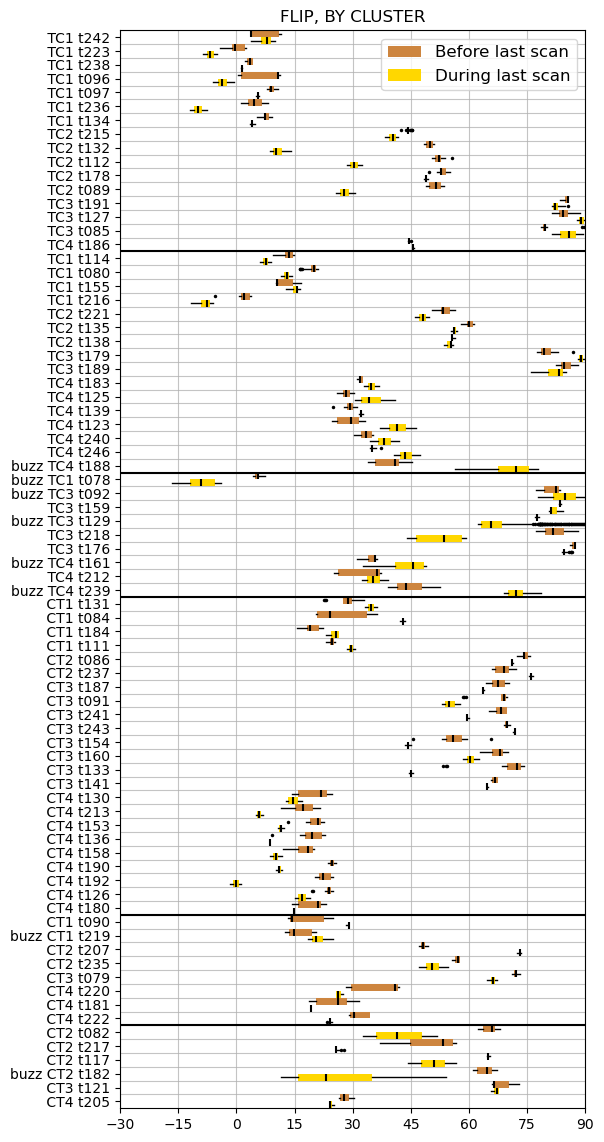

In [26]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before_flip,
    clicks_during=click_ch1_all_during_flip,
    cut_list=cluster_cut,
    flip_xticks=True,
)
# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before_flip)))
ax.set_yticklabels(list(str_all.values()))
ax.set_yticks(np.arange(len(click_ch1_all_before_flip))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

plt.title("FLIP, BY CLUSTER")
plt.show()

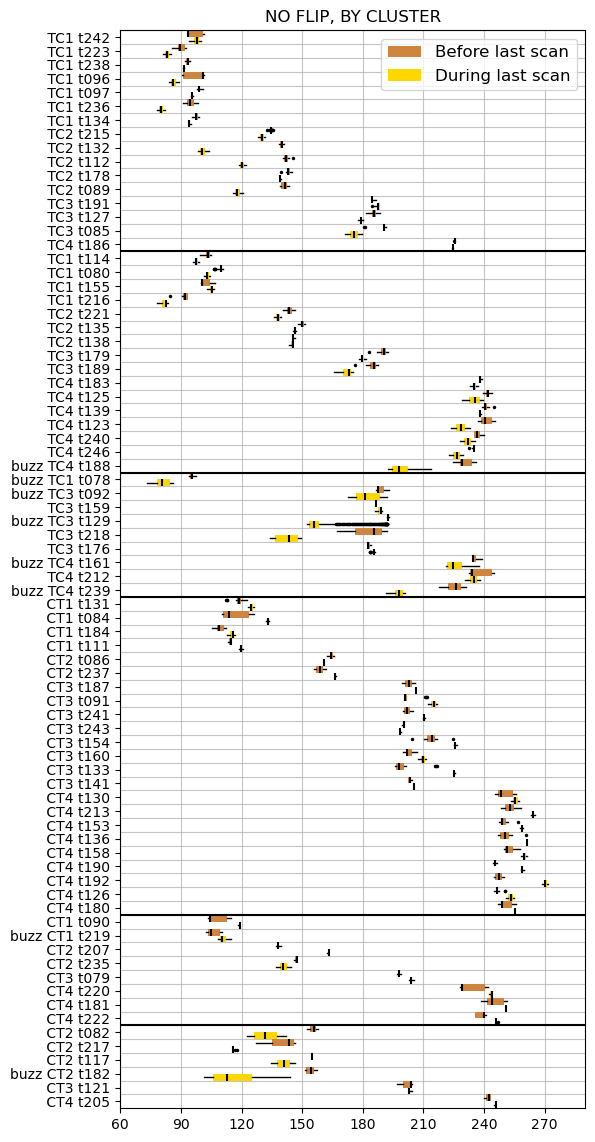

In [27]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before,
    clicks_during=click_ch1_all_during,
    cut_list=cluster_cut,
    flip_xticks=False,
)
# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before_flip)))
ax.set_yticklabels(list(str_all.values()))
ax.set_yticks(np.arange(len(click_ch1_all_before_flip))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

plt.title("NO FLIP, BY CLUSTER")
plt.show()

## Plot all scenarios together

In [28]:
click_ch1_all_before = dict()
click_ch1_all_during = dict()
click_ch1_all_before_flip = dict()
click_ch1_all_during_flip = dict()
str_all = dict()
iqr_all_before = dict()
iqr_all_during = dict()
buzz_str = ""
buzz_trial_idx = []

for k in trial_idx_scenario_dict:
    # print cluster name
    # print(k)

    # go through all trials in this cluster
    for trial_idx in trial_idx_scenario_dict[k]:
        # print(f"trial {trial_idx}")

        # get clicks BEFORE last scan
        _, df_ch1_before = get_clicks(trial_idx, timeframe="before")
        df_ch1_before["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_before["enso_angle"])
        click_ch1_all_before[trial_idx] = df_ch1_before["enso_angle"].values
        click_ch1_all_before_flip[trial_idx] = df_ch1_before["enso_angle_flip"].values

        # get clicks DURING last scan
        _, df_ch1_during = get_clicks(trial_idx, timeframe="during")
        df_ch1_during["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_during["enso_angle"])
        click_ch1_all_during[trial_idx] = df_ch1_during["enso_angle"].values
        click_ch1_all_during_flip[trial_idx] = df_ch1_during["enso_angle_flip"].values

        # If buzz initiated during last scan
        if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
            # print("trial {trial_idx}: buzz initiated during last scan!")
            buzz_str = "buzz"
            buzz_trial_idx.append(trial_idx)
        else:
            buzz_str = ""

        # get scenario
        tca = df_summary.loc[trial_idx]["TARGET_ANGLE"]

        # assemble trial string
        str_all[trial_idx] = f"{buzz_str} {tca} t{trial_idx:03d}"

        # assemble trial IQR string
        iqr_all_before[trial_idx] = iqr(df_ch1_before["enso_angle_flip"], nan_policy="omit")
        iqr_all_during[trial_idx] = iqr(df_ch1_during["enso_angle_flip"], nan_policy="omit")

Trial 242: df_ch0 is empty
Trial 223: df_ch0 is empty
Trial 236: df_ch0 is empty
Trial 134: df_ch0 is empty
Trial 114: df_ch0 is empty
Trial 80: df_ch0 is empty
Trial 155: df_ch0 is empty
Trial 216: df_ch0 is empty
Trial 78: df_ch0 is empty
Trial 215: df_ch0 is empty
Trial 132: df_ch0 is empty
Trial 112: df_ch0 is empty
Trial 89: df_ch0 is empty
Trial 221: df_ch0 is empty
Trial 135: df_ch0 is empty
Trial 85: df_ch0 is empty
Trial 189: df_ch0 is empty
Trial 129: df_ch0 is empty
Trial 218: df_ch0 is empty
Trial 176: df_ch0 is empty
Trial 183: df_ch0 is empty
Trial 125: df_ch0 is empty
Trial 123: df_ch0 is empty
Trial 240: df_ch0 is empty
Trial 246: df_ch0 is empty
Trial 188: df_ch0 is empty
Trial 161: df_ch0 is empty
Trial 212: df_ch0 is empty
Trial 239: df_ch0 is empty
Trial 84: df_ch0 is empty
Trial 184: df_ch0 is empty
Trial 111: df_ch0 is empty
Trial 90: df_ch0 is empty
Trial 219: df_ch0 is empty
Trial 86: df_ch0 is empty
Trial 237: df_ch0 is empty
Trial 207: df_ch0 is empty
Trial 23

In [29]:
# Get cluster cut
scenario_cut = np.cumsum([len(x) for x in list(trial_idx_scenario_dict.values())])
scenario_cut

array([12, 20, 30, 41, 47, 55, 65, 78])

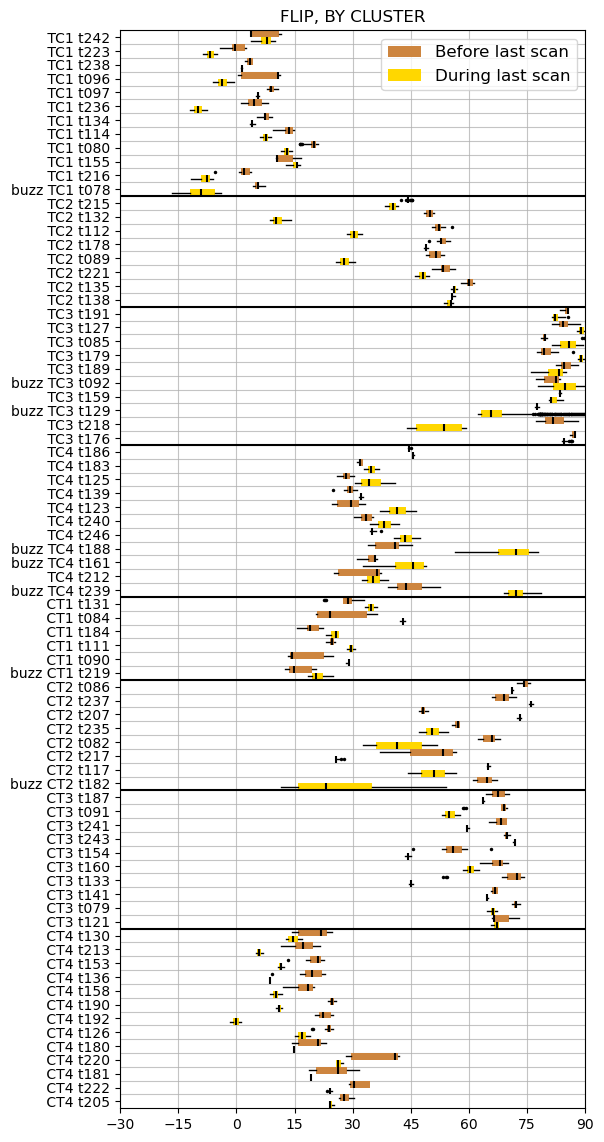

In [30]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before_flip,
    clicks_during=click_ch1_all_during_flip,
    cut_list=scenario_cut,
    flip_xticks=True,
)
# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before_flip)))
ax.set_yticklabels(list(str_all.values()))
ax.set_yticks(np.arange(len(click_ch1_all_before_flip))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

plt.title("FLIP, BY CLUSTER")
plt.show()

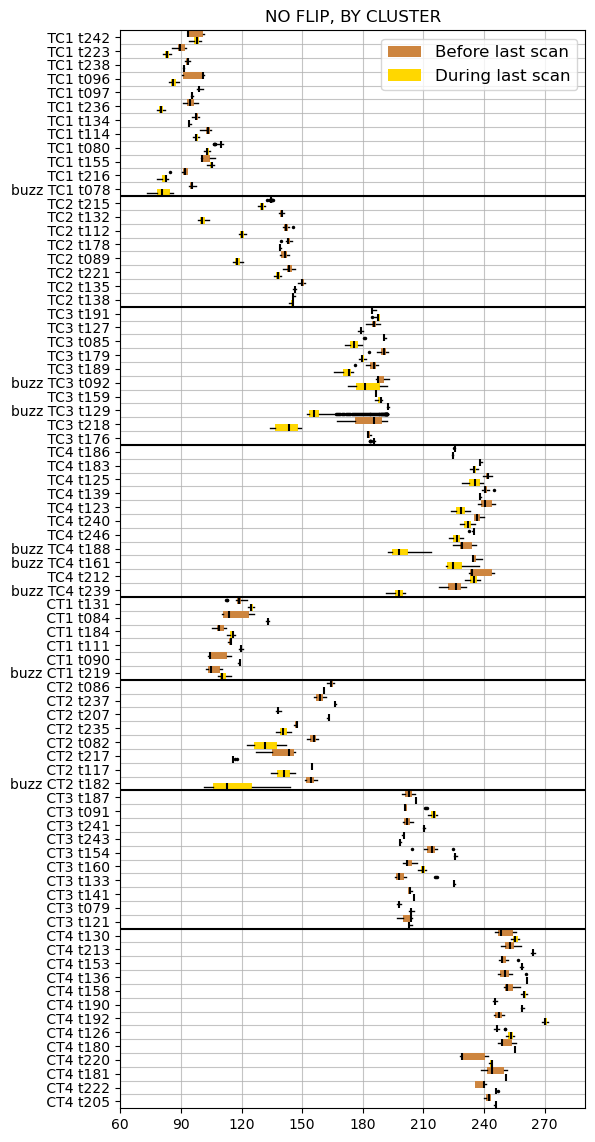

In [31]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before,
    clicks_during=click_ch1_all_during,
    cut_list=scenario_cut,
    flip_xticks=False,
)
# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before_flip)))
ax.set_yticklabels(list(str_all.values()))
ax.set_yticks(np.arange(len(click_ch1_all_before_flip))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

plt.title("NO FLIP, BY CLUSTER")
plt.show()

## Add clustering color code to scenario plot

In [32]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [33]:
idx_height = []
color_accum = []
for tca in SCENARIO_STR:

    for cluster_idx, cluster_color in zip(range(6), color_cluster_seq_7):
        df_cluster = df_cluster_clean_7[cluster_idx]
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) != 0:
            idx_height.append(len(df_tca))
            color_accum.append(cluster_color)

idx_bottom = np.cumsum([0] + idx_height)

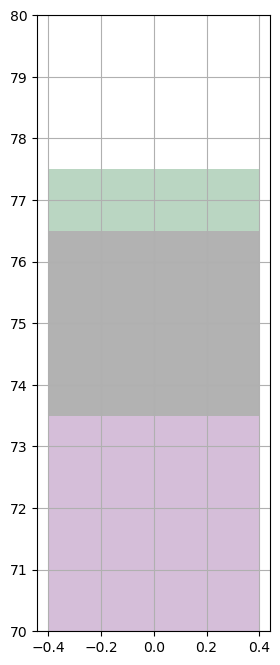

In [34]:
# Test plotting color blocks for clusters
fig, ax_add = plt.subplots(1, 1, figsize=(3,8))
for h, b, c in zip(idx_height, idx_bottom[:-1], color_accum):
    ax_add.bar(
        0,
        height=h,
        bottom=b-0.5,
        color=c, alpha=0.3
    )
ax_add.invert_yaxis()
ax_add.set_yticks(np.arange(70, 81, 1))
ax_add.grid()
ax_add.set_ylim(70, 80)
plt.show()

In [35]:
click_ch1_all_before = dict()
click_ch1_all_during = dict()
click_ch1_all_before_flip = dict()
click_ch1_all_during_flip = dict()
str_all = dict()
iqr_all_before = dict()
iqr_all_during = dict()
buzz_str = ""
buzz_trial_idx = []

for k in trial_idx_scenario_dict:
    # print cluster name
    # print(k)

    # go through all trials in this cluster
    for trial_idx in trial_idx_scenario_dict[k]:
        # print(f"trial {trial_idx}")

        # get clicks BEFORE last scan
        _, df_ch1_before = get_clicks(trial_idx, timeframe="before")
        df_ch1_before["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_before["enso_angle"])
        click_ch1_all_before[trial_idx] = df_ch1_before["enso_angle"].values
        click_ch1_all_before_flip[trial_idx] = df_ch1_before["enso_angle_flip"].values

        # get clicks DURING last scan
        _, df_ch1_during = get_clicks(trial_idx, timeframe="during")
        df_ch1_during["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1_during["enso_angle"])
        click_ch1_all_during[trial_idx] = df_ch1_during["enso_angle"].values
        click_ch1_all_during_flip[trial_idx] = df_ch1_during["enso_angle_flip"].values

        # If buzz initiated during last scan
        if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
            # print("trial {trial_idx}: buzz initiated during last scan!")
            buzz_str = "buzz"
            buzz_trial_idx.append(trial_idx)
        else:
            buzz_str = ""

        # assemble trial string
        str_all[trial_idx] = f"{buzz_str} t{trial_idx:03d}"

        # assemble trial IQR string
        iqr_all_before[trial_idx] = iqr(df_ch1_before["enso_angle_flip"], nan_policy="omit")
        iqr_all_during[trial_idx] = iqr(df_ch1_during["enso_angle_flip"], nan_policy="omit")

Trial 242: df_ch0 is empty
Trial 223: df_ch0 is empty
Trial 236: df_ch0 is empty
Trial 134: df_ch0 is empty
Trial 114: df_ch0 is empty
Trial 80: df_ch0 is empty
Trial 155: df_ch0 is empty
Trial 216: df_ch0 is empty
Trial 78: df_ch0 is empty
Trial 215: df_ch0 is empty
Trial 132: df_ch0 is empty
Trial 112: df_ch0 is empty
Trial 89: df_ch0 is empty
Trial 221: df_ch0 is empty
Trial 135: df_ch0 is empty
Trial 85: df_ch0 is empty
Trial 189: df_ch0 is empty
Trial 129: df_ch0 is empty
Trial 218: df_ch0 is empty
Trial 176: df_ch0 is empty
Trial 183: df_ch0 is empty
Trial 125: df_ch0 is empty
Trial 123: df_ch0 is empty
Trial 240: df_ch0 is empty
Trial 246: df_ch0 is empty
Trial 188: df_ch0 is empty
Trial 161: df_ch0 is empty
Trial 212: df_ch0 is empty
Trial 239: df_ch0 is empty
Trial 84: df_ch0 is empty
Trial 184: df_ch0 is empty
Trial 111: df_ch0 is empty
Trial 90: df_ch0 is empty
Trial 219: df_ch0 is empty
Trial 86: df_ch0 is empty
Trial 237: df_ch0 is empty
Trial 207: df_ch0 is empty
Trial 23

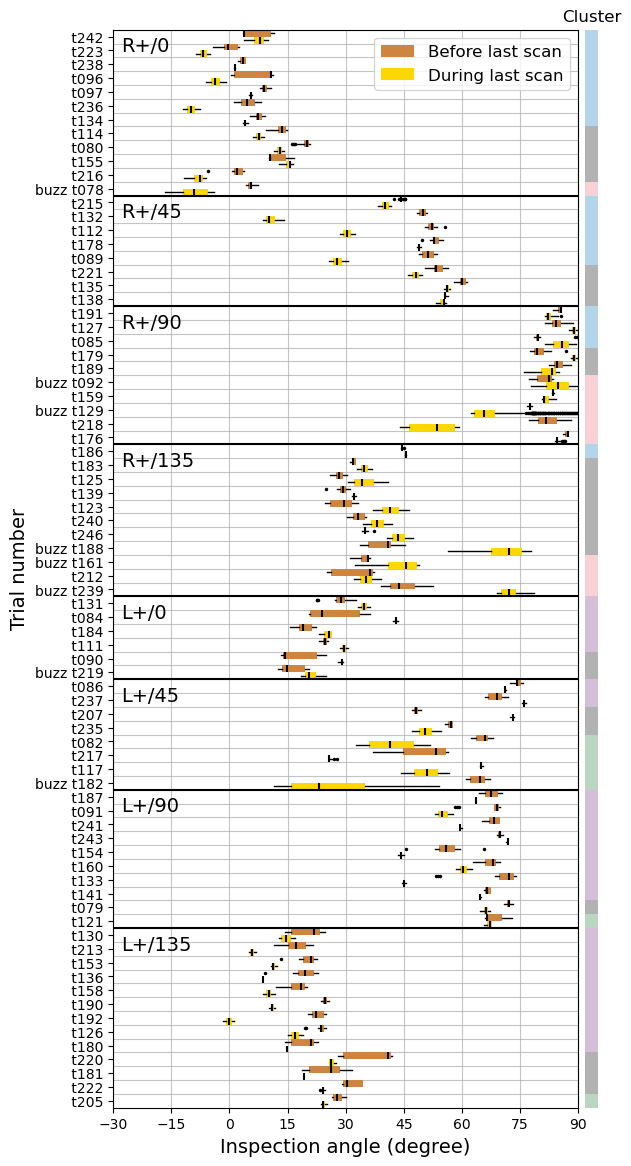

In [36]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before_flip,
    clicks_during=click_ch1_all_during_flip,
    cut_list=scenario_cut,
    flip_xticks=True,
)

# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before_flip)))
ax.set_yticklabels(str_all.values())
ax.set_yticks(np.arange(len(click_ch1_all_before_flip))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.tick_params(axis="x", which="major", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

# Add color code for vertical axis
ax_pos = ax.get_position()
ax_add = fig.add_axes([ax_pos.x0+ax_pos.width+0.01, ax_pos.y0, 0.025, ax_pos.height])
ax_add.set_xticks([])
ax_add.set_yticks([])
for h, b, c in zip(idx_height, idx_bottom[:-1], color_accum):
    ax_add.bar(0, height=h, bottom=b-0.5, color=c, alpha=0.3)
ax_add.set_ylim(-0.5, 77.5)
ax_add.invert_yaxis()
ax_add.axis("off")

# Label large y sections
x_offset = -28
# y_offset_all = [6, 16, 24, 35.5, 44, 51, 60, 71.5]
y_offset_all = [0, 12, 20, 30, 41, 47, 55, 65]
for y_offset, c_name in zip(y_offset_all, TARGET_ANGLE_STR_NEW):
    ax.text(x_offset, y_offset, c_name, fontsize=14,
            ha="left", va="top")

ax.set_xlabel("Inspection angle (degree)", fontsize=14)
ax.set_ylabel("Trial number", fontsize=14)
ax_add.set_title("Cluster", fontsize=12)

plt.show()

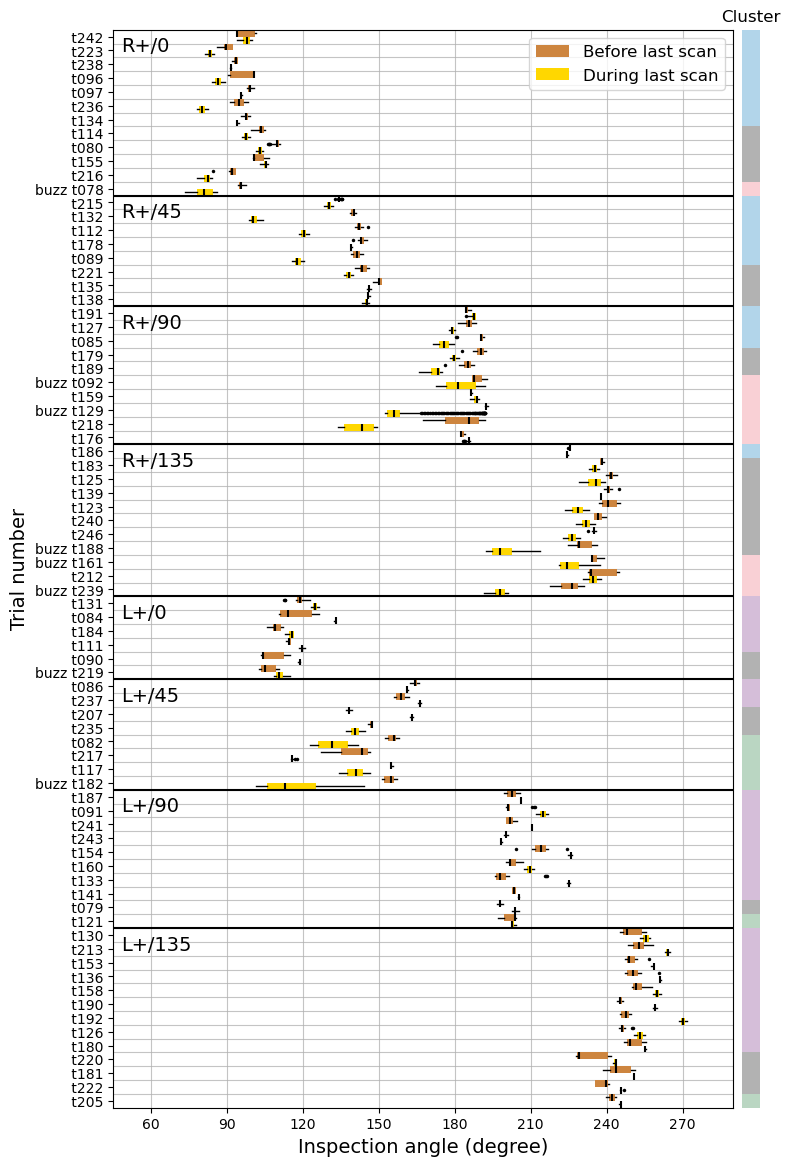

In [37]:
fig, ax = plot_iqr(
    clicks_before=click_ch1_all_before,
    clicks_during=click_ch1_all_during,
    cut_list=scenario_cut,
    flip_xticks=False,
    figsize=(8, 14)
)

# Handling ticks and grid lines
ax.set_yticks(np.arange(len(click_ch1_all_before)))
ax.set_yticklabels(str_all.values())
ax.set_yticks(np.arange(len(click_ch1_all_before))-0.5, minor=True)
ax.tick_params(axis="y", which="minor", left=False)
ax.tick_params(axis="x", which="major", left=False)
ax.grid(axis="y", which="minor", alpha=0.75)
ax.grid(axis="x", which="major", alpha=0.75)
ax.set_ylim(-0.5, 77.5)
ax.invert_yaxis()

# Add color code for vertical axis
ax_pos = ax.get_position()
ax_add = fig.add_axes([ax_pos.x0+ax_pos.width+0.01, ax_pos.y0, 0.025, ax_pos.height])
ax_add.set_xticks([])
ax_add.set_yticks([])
for h, b, c in zip(idx_height, idx_bottom[:-1], color_accum):
    ax_add.bar(0, height=h, bottom=b-0.5, color=c, alpha=0.3)
ax_add.set_ylim(-0.5, 77.5)
ax_add.invert_yaxis()
ax_add.axis("off")

# Label large y sections
x_offset = 48
# y_offset_all = [6, 16, 24, 35.5, 44, 51, 60, 71.5]
y_offset_all = [0, 12, 20, 30, 41, 47, 55, 65]
for y_offset, c_name in zip(y_offset_all, TARGET_ANGLE_STR_NEW):
    ax.text(x_offset, y_offset, c_name, fontsize=14,
            ha="left", va="top")

ax.set_xlim(45, 290)

ax.set_xlabel("Inspection angle (degree)", fontsize=14)
ax.set_ylabel("Trial number", fontsize=14)
ax_add.set_title("Cluster", fontsize=12)

plt.show()